# ChEMBL *P. falciparum* Data Cleaning and Processing for DHFR inhibitors

## Introduction

This is probably the most important step of all, since the data cleaning reflects directly in the **quality of your model**. For this specific notebook we will be doing the data cleaning and processing of *P. falciparum DHFR Inhibitors*

### Importing the libraries:

For the purpose of cleaning the dataset, we will be using mainly rdkit and pandas functions. For the plotting section we will use *seaborn* and *matplotlib*.

In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat
from rdkit.Chem import rdmolops
from IPython.display import HTML
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import session_info

# Code to show df properly
# Correcting the bug that shows only once the MOL structure in a jupyter notebook
# This is very important if you want to see more than once the mol depiction
def show_df(df):
    return HTML(df.to_html(notebook=True))

## Cleaning Process

### Loading the dataset

In [2]:
plasmodium_dhfr_chembl = pd.read_csv('../datasets/raw/data/plasmodium_dhfr_chembl_compounds.csv')
print(f"The shape of the dataset is {plasmodium_dhfr_chembl.shape}")
plasmodium_dhfr_chembl.head(5)

The shape of the dataset is (145, 9)


,molecule_chembl_id,smiles,pKi_mean_value,mean_Ki_value,pKi_first_value,first_Ki_value,pKi_last_value,last_Ki_value,target_organism
0,CHEMBL2364573,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.098723,7.966667,8.327902,4.7,7.838632,14.5,Plasmodium falciparum K1
1,CHEMBL324775,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,6.675666,211.025000,8.508638,3.1,6.351542,445.1,Plasmodium falciparum K1
2,CHEMBL416373,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,7.267721,53.985714,9.397940,0.4,8.251812,5.6,Plasmodium falciparum K1
3,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,6.321027,477.500000,8.142668,7.2,5.947075,1129.6,Plasmodium falciparum K1
4,CHEMBL119188,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,6.608712,246.200000,9.221849,0.6,6.113453,770.1,Plasmodium falciparum K1


### Removing the salts, neutralize atoms and keep only the largest fragments

In [3]:
# Defining the salts we want to remove from the database
remover = SaltRemover(defnData="[Cl,Br,Na,K,Gd]")

# Defining the function to neutralize the atoms in organic molecules
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

def keep_largest_fragment(mol):
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

In [4]:
# Running the same function again (it's better to define a function and just call it again...)
mols = []
for i, smi in enumerate(plasmodium_dhfr_chembl.smiles):
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = remover.StripMol(neutralize_atoms(mol))
        mols.append(mol)
    except:
        print(smi,i)

,molecule_chembl_id,smiles,pKi_mean_value,mean_Ki_value,pKi_first_value,first_Ki_value,pKi_last_value,last_Ki_value,target_organism,ROMol
0,CHEMBL2364573,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.098723,7.966667,8.327902,4.7,7.838632,14.5,Plasmodium falciparum K1,
1,CHEMBL324775,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,6.675666,211.025000,8.508638,3.1,6.351542,445.1,Plasmodium falciparum K1,
2,CHEMBL416373,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,7.267721,53.985714,9.397940,0.4,8.251812,5.6,Plasmodium falciparum K1,

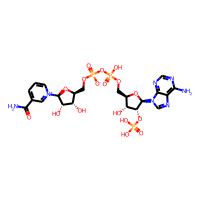
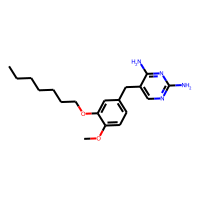
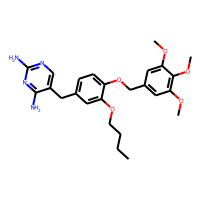

In [5]:
PandasTools.AddMoleculeColumnToFrame(plasmodium_dhfr_chembl, smilesCol='smiles')
plasmodium_dhfr_chembl.head(3)

,molecule_chembl_id,smiles,pKi_mean_value,mean_Ki_value,pKi_first_value,first_Ki_value,pKi_last_value,last_Ki_value,target_organism,ROMol,Mol_Clean
0,CHEMBL2364573,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.098723,7.966667,8.327902,4.7,7.838632,14.5,Plasmodium falciparum K1,,
1,CHEMBL324775,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,6.675666,211.025000,8.508638,3.1,6.351542,445.1,Plasmodium falciparum K1,,
2,CHEMBL416373,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,7.267721,53.985714,9.397940,0.4,8.251812,5.6,Plasmodium falciparum K1,,
3,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,6.321027,477.500000,8.142668,7.2,5.947075,1129.6,Plasmodium falciparum K1,,
4,CHEMBL119188,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,6.608712,246.200000,9.221849,0.6,6.113453,770.1,Plasmodium falciparum K1,,

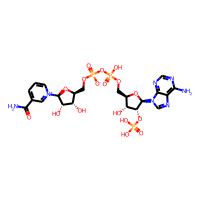
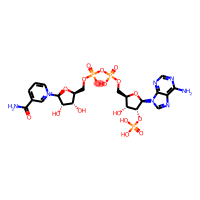
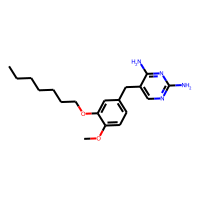
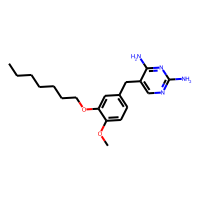
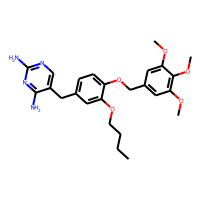
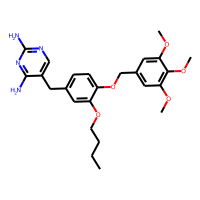
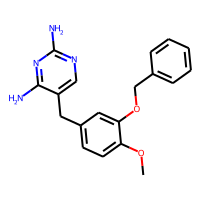
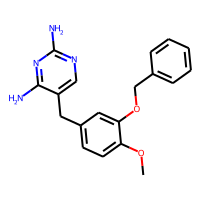
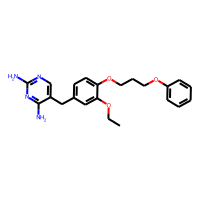
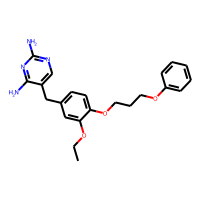

In [6]:
# Keep largest fragment
plasmodium_dhfr_chembl["Mol_Clean"] = plasmodium_dhfr_chembl.ROMol.apply(keep_largest_fragment)

# Strip mol
plasmodium_dhfr_chembl["Mol_Clean"] = plasmodium_dhfr_chembl.Mol_Clean.apply(remover.StripMol)

# Neutralize atoms
plasmodium_dhfr_chembl["Mol_Clean"] = plasmodium_dhfr_chembl.Mol_Clean.apply(neutralize_atoms)

show_df(plasmodium_dhfr_chembl.head(5))

Creating a column of smiles from the `Mol_Clean` structures and lastly, we can save the dataset into a '.csv' file with the following variables:
* molecule_chembl_id
* smiles_clean
* pKi_mean_value
* pKi_last_value
* pKi_first_value
* target_organism

,molecule_chembl_id,smiles_clean,pKi_mean_value,pKi_first_value,pKi_last_value,target_organism,ROMol
0,CHEMBL2364573,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)(O)OP(=O)...,8.098723,8.327902,7.838632,Plasmodium falciparum K1,
1,CHEMBL324775,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,6.675666,8.508638,6.351542,Plasmodium falciparum K1,
2,CHEMBL416373,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,7.267721,9.397940,8.251812,Plasmodium falciparum K1,
3,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,6.321027,8.142668,5.947075,Plasmodium falciparum K1,
4,CHEMBL119188,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,6.608712,9.221849,6.113453,Plasmodium falciparum K1,

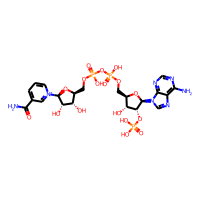
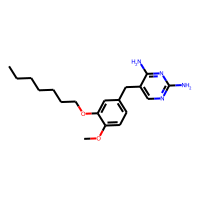
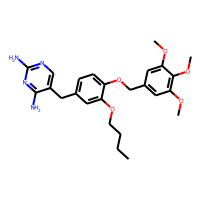
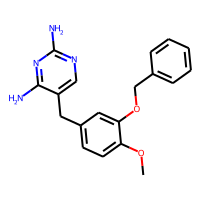
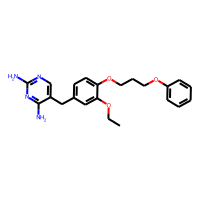

In [7]:
# transforming the mol_clean variable into smiles:
plasmodium_dhfr_chembl['smiles_clean'] = plasmodium_dhfr_chembl.Mol_Clean.apply(Chem.MolToSmiles)

# Saving only the important variables
plasmodium_dhfr_chembl = plasmodium_dhfr_chembl[['molecule_chembl_id', 'smiles_clean', 'pKi_mean_value', 'pKi_first_value', 'pKi_last_value', 'target_organism']]

# Checking one final time if the smiles_clean can be interconverted to mol again
PandasTools.AddMoleculeColumnToFrame(plasmodium_dhfr_chembl, smilesCol='smiles_clean')
show_df(plasmodium_dhfr_chembl.head(5))

## Saving the output

In [8]:
# Dropping the column
plasmodium_dhfr_chembl.drop('ROMol', axis=1, inplace=True)

# Saving the final dataset to a clean csv:
plasmodium_dhfr_chembl.to_csv('cleaned_data/clean_plasmdoium_dhfr_chembl.csv', index=False)